In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

print(keras.__version__)
print(tf.__version__)

#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=5 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../data/data_batches/batch_4/patch_img/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(img_path)
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

#Capture mask/label info as a list
train_masks = [] 

for directory_path in glob.glob("../data/data_batches/batch_4/patch_mask/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(mask_path)
        mask = cv2.imread(mask_path, 0)       
        # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
# X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
# #Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.3, random_state = 0)


#Full Data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

# Add print statements to check tensor shapes
print("Input shapes:")
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)


###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

Segmentation Models: using `keras` framework.
2.13.1
2.14.0
(4666, 256, 256, 3)
(4666, 256, 256)


C:\Users\sagni\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class values in the dataset are ...  [0 1 2 3 4]
Input shapes:
X_train shape: (3732, 256, 256, 3)
y_train_cat shape: (3732, 256, 256, 5)
X_test shape: (934, 256, 256, 3)
y_test_cat shape: (934, 256, 256, 5)


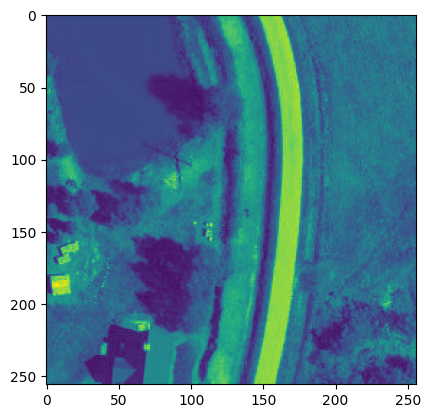

In [3]:
plt.imshow(train_images[0, :,:,0])

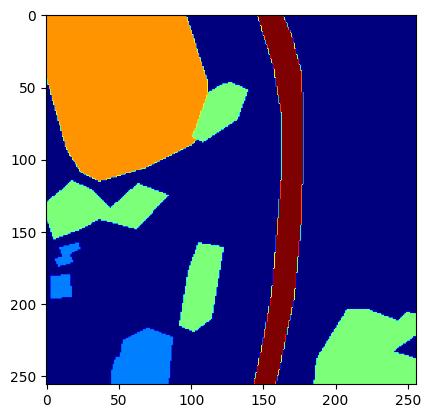

In [2]:
plt.imshow(train_masks[0], cmap='jet')

In [4]:
# Assuming you have one-hot encoded masks
# train_masks_cat and test_masks_cat are your one-hot encoded masks

num_classes = n_classes  # Set the number of classes to 5

# For training data
class_pixel_counts_train = np.sum(train_masks_cat, axis=(0, 1, 2))
print("Class-wise pixel counts for training data:")
for class_index in range(num_classes):
    pixel_count = class_pixel_counts_train[class_index]
    print(f"Class {class_index}: {pixel_count} pixels")

# For testing data
class_pixel_counts_test = np.sum(test_masks_cat, axis=(0, 1, 2))
print("Class-wise pixel counts for testing data:")
for class_index in range(num_classes):
    pixel_count = class_pixel_counts_test[class_index]
    print(f"Class {class_index}: {pixel_count} pixels")


Class-wise pixel counts for training data:
Class 0: 16777216.0 pixels
Class 1: 3964561.0 pixels
Class 2: 16777216.0 pixels
Class 3: 16777216.0 pixels
Class 4: 7231817.0 pixels
Class-wise pixel counts for testing data:
Class 0: 16777216.0 pixels
Class 1: 1179208.0 pixels
Class 2: 16777216.0 pixels
Class 3: 4379063.0 pixels
Class 4: 1966442.0 pixels


In [5]:
# Callbacks
BACKBONE = 'resnet34'
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

os.makedirs(f'Checkpoints/{BACKBONE}', exist_ok= True)
os.makedirs(f'History/{BACKBONE}', exist_ok = True)

checkpoint = ModelCheckpoint(f'Checkpoints/{BACKBONE}/weights-improvement_{BACKBONE}.hdf5', monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor="val_iou_score", min_delta=0, patience= 20, verbose= 1, mode= "max", baseline= None, restore_best_weights= False, start_from_epoch= 20)
log_csv = CSVLogger(f'History/{BACKBONE}/training-history-{BACKBONE}.csv', separator=',', append=False)
callbacks_list = [checkpoint, early_stop, log_csv]

In [6]:
from keras.models import load_model
import segmentation_models as sm
import keras

# Reused parameters in all models
n_classes = 5
activation = 'softmax'

LR = 0.0001
optimizer = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.20, 0.20, 0.20, 0.20, 0.20]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (2 * focal_loss)

# Reused metrics for evaluation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Load the model
model1 = load_model(f'../FurtherTraining/CheckPoints/{BACKBONE}/weights-improvement_resnet34.hdf5', compile=False)

# Compile the model
model1.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Now you can further train the model using fit method
model1.fit(X_train1, y_train_cat, epochs=200, batch_size=2, validation_data=(X_test1, y_test_cat), callbacks = callbacks_list)


Epoch 1/200
1866/1866 [==============================] - ETA: 0s - loss: 0.9247 - iou_score: 0.6572 - f1-score: 0.7175
Epoch 1: val_iou_score improved from -inf to 0.70222, saving model to Checkpoints/resnet34\weights-improvement_resnet34.hdf5


C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1866/1866 [==============================] - 2690s 1s/step - loss: 0.9247 - iou_score: 0.6572 - f1-score: 0.7175 - val_loss: 0.9250 - val_iou_score: 0.7022 - val_f1-score: 0.7647
Epoch 2/200
1866/1866 [==============================] - ETA: 0s - loss: 0.9177 - iou_score: 0.6773 - f1-score: 0.7351
Epoch 2: val_iou_score did not improve from 0.70222
1866/1866 [==============================] - 2985s 2s/step - loss: 0.9177 - iou_score: 0.6773 - f1-score: 0.7351 - val_loss: 0.9206 - val_iou_score: 0.7000 - val_f1-score: 0.7606
Epoch 3/200
1866/1866 [==============================] - ETA: 0s - loss: 0.9133 - iou_score: 0.7002 - f1-score: 0.7560
Epoch 3: val_iou_score improved from 0.70222 to 0.70433, saving model to Checkpoints/resnet34\weights-improvement_resnet34.hdf5
1866/1866 [==============================] - 3150s 2s/step - loss: 0.9133 - iou_score: 0.7002 - f1-score: 0.7560 - val_loss: 0.9255 - val_iou_score: 0.7043 - val_f1-score: 0.7661
Epoch 4/200
1866/1866 [======================

KeyboardInterrupt: 

In [7]:
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

30/30 [==============================] - 80s 3s/step
Mean IoU = 0.6753839


In [8]:
import numpy as np

# Assuming n_classes = 5
n_classes = 5

# Initialize your confusion matrix 'values'
# Replace this with your actual confusion matrix
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

# Calculate IoU for each class
class_IoU = []
for i in range(n_classes):
    numerator = values[i, i]
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i]

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-10
    class_IoU.append(numerator / (denominator + epsilon))

# Print IoU for each class
for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_IoU[i]}")


IoU for class 1 is: 0.6889398995245608
IoU for class 2 is: 0.6681829152819294
IoU for class 3 is: 0.7380000978298317
IoU for class 4 is: 0.7518906651374644
IoU for class 5 is: 0.5299063932841407


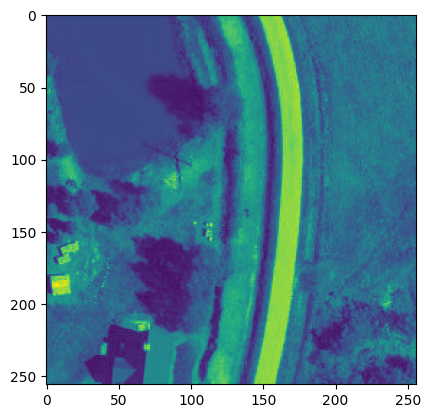

In [9]:
plt.imshow(train_images[0, :,:,0])

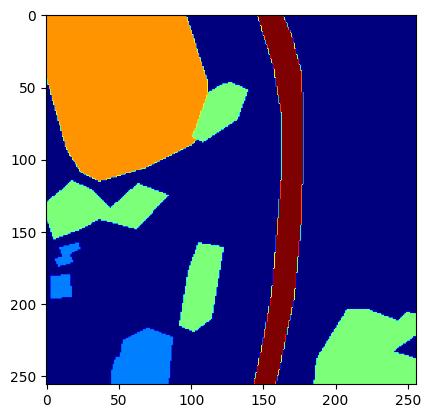

In [10]:
plt.imshow(train_masks[0], cmap='jet')

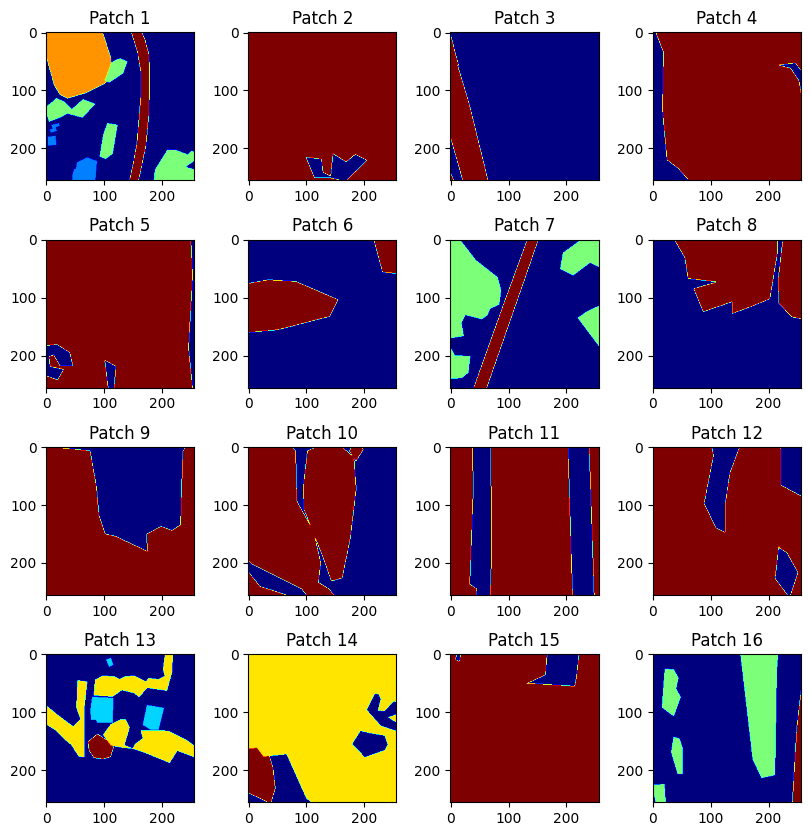

In [11]:
import matplotlib.pyplot as plt

# Create a figure with a larger size
fig = plt.figure(figsize=(10, 10))

# Assuming train_masks contains at least 16 mask images
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    ax.imshow(train_masks[i], cmap='jet') #16 patches make a single image
    ax.set_title(f"Patch {i + 1}")  # Add a title for each subplot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()  # Display all 16 images

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


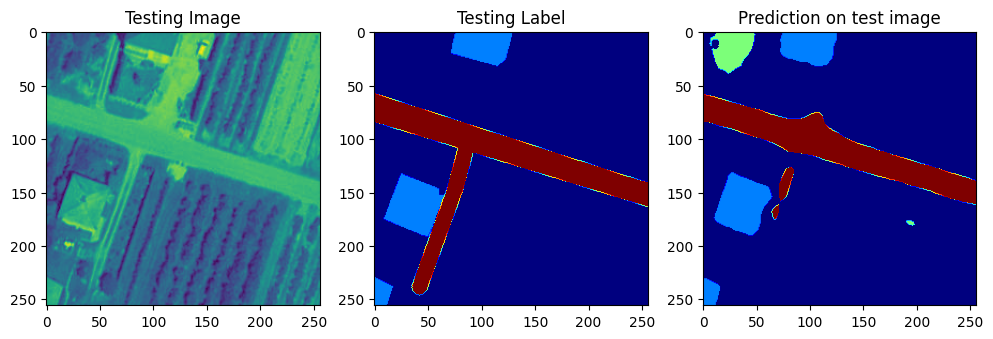

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


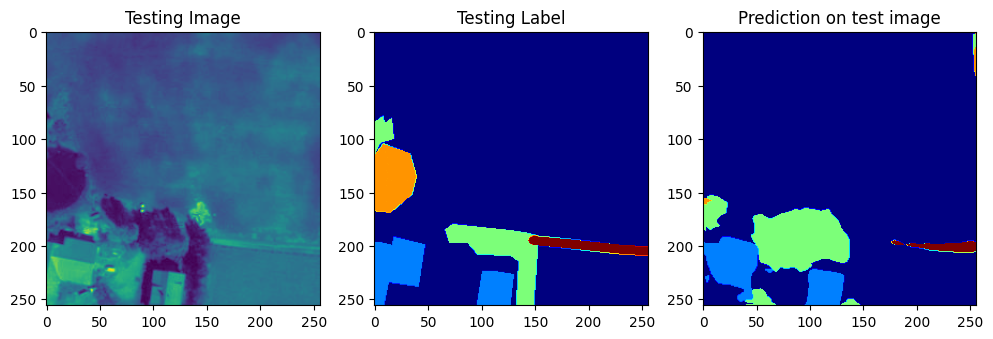

(1, 256, 256, 3)
1/1 [==============================] - 0s 96ms/step
(256, 256)


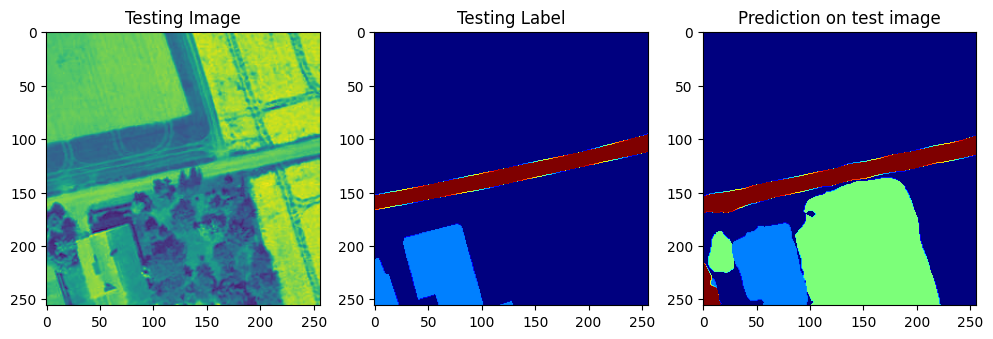

(1, 256, 256, 3)
1/1 [==============================] - 0s 95ms/step
(256, 256)


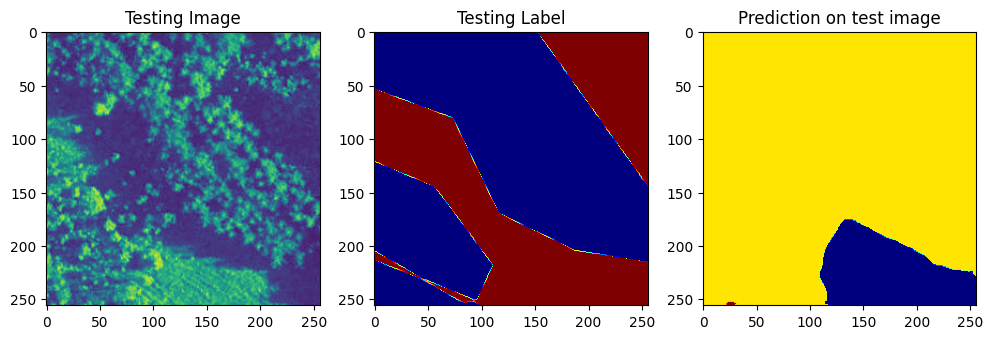

(1, 256, 256, 3)
1/1 [==============================] - 0s 112ms/step
(256, 256)


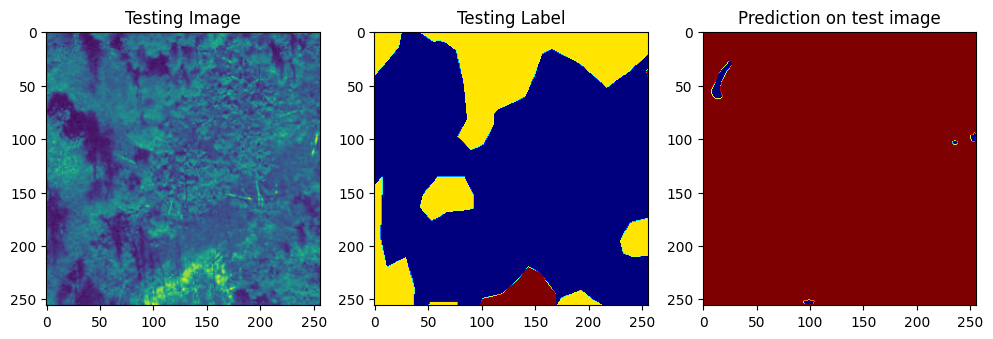

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


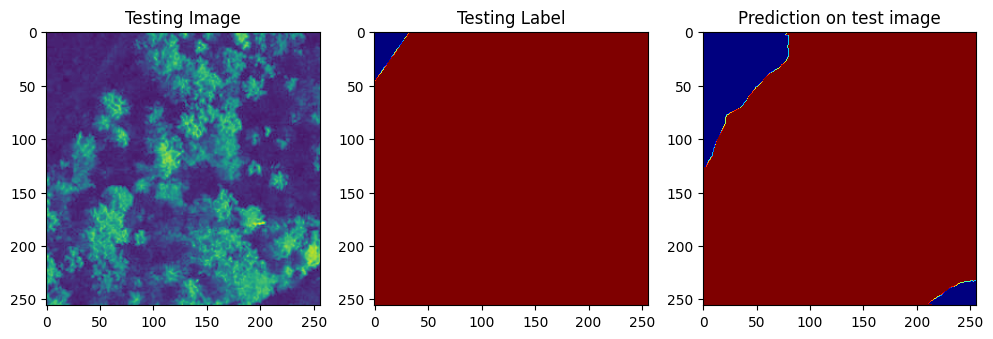

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


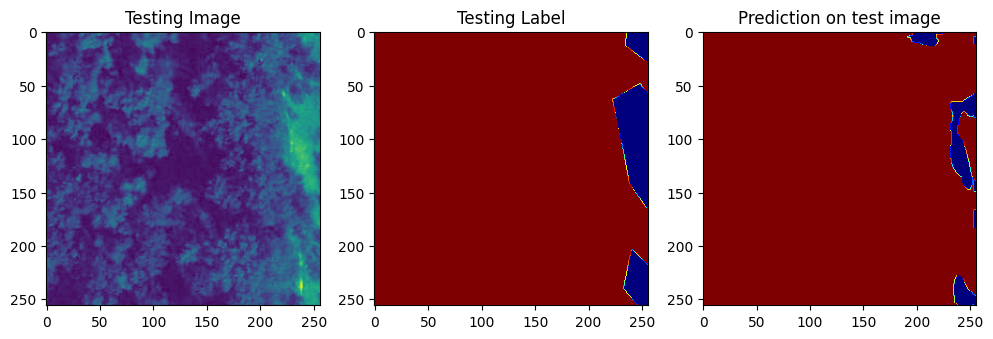

(1, 256, 256, 3)
1/1 [==============================] - 0s 116ms/step
(256, 256)


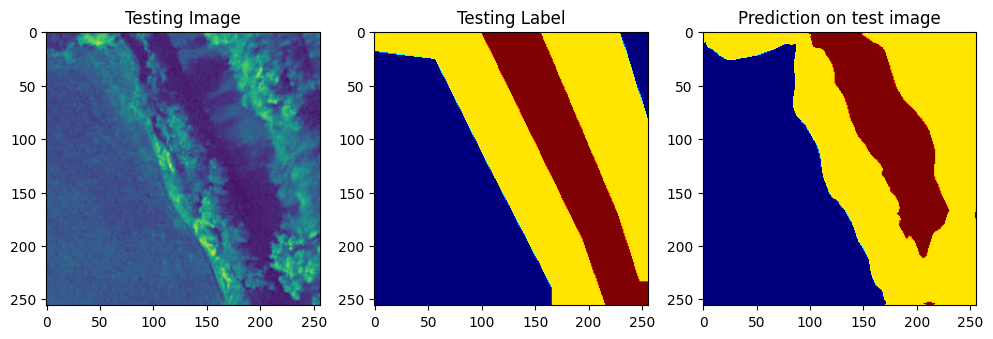

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


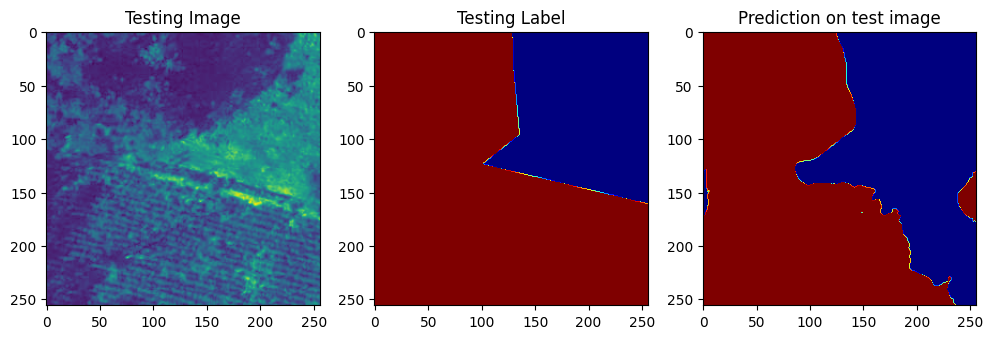

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


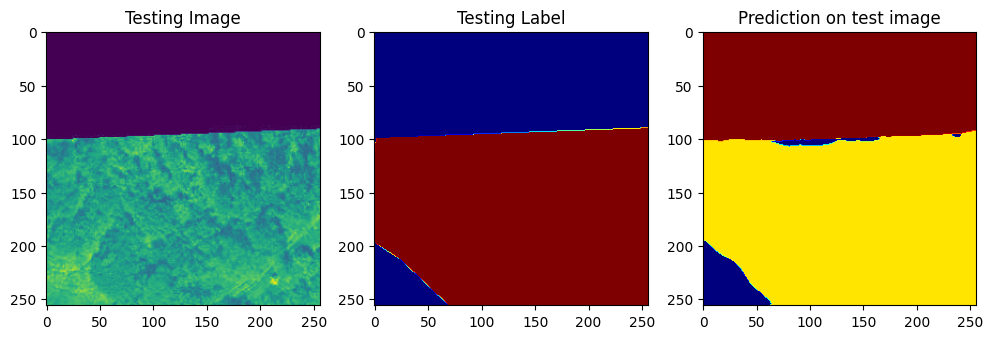

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


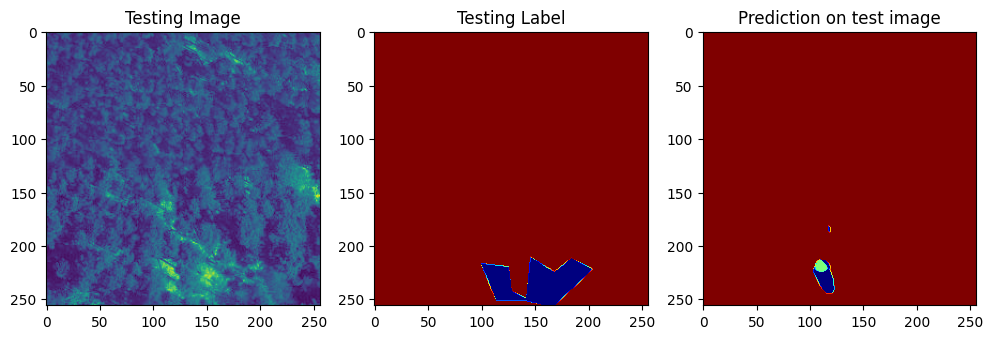

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


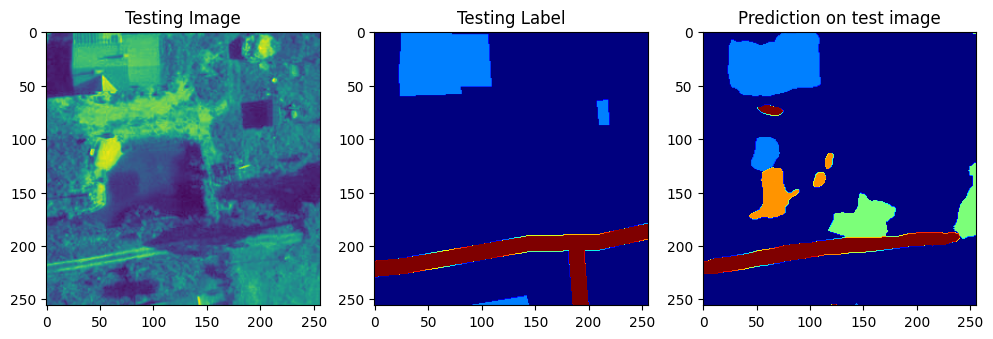

(1, 256, 256, 3)
1/1 [==============================] - 0s 126ms/step
(256, 256)


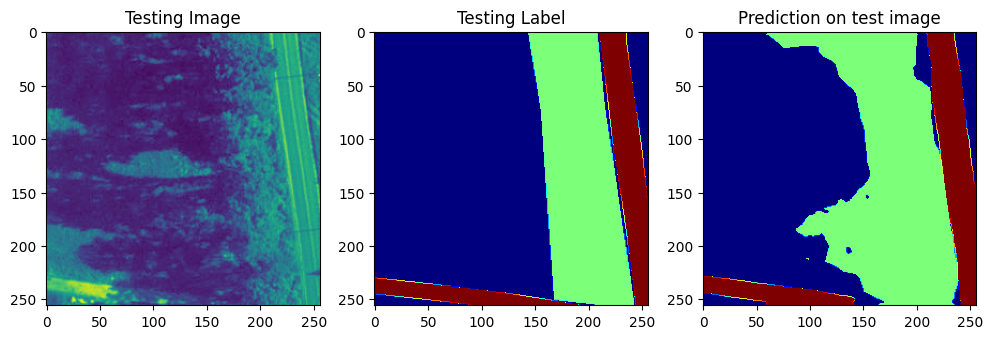

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


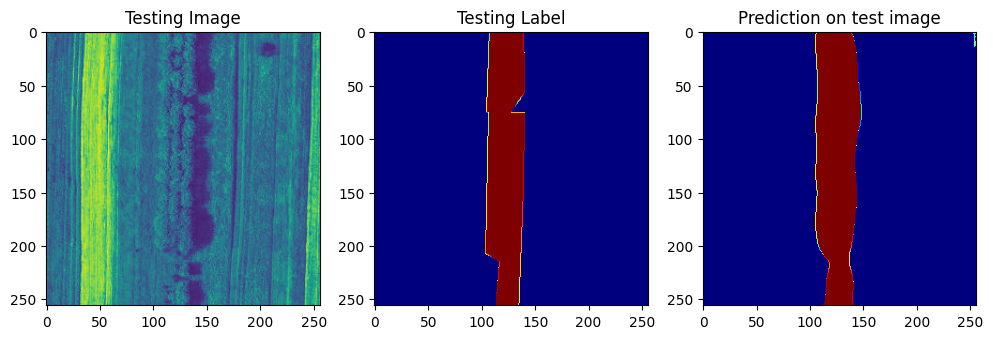

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


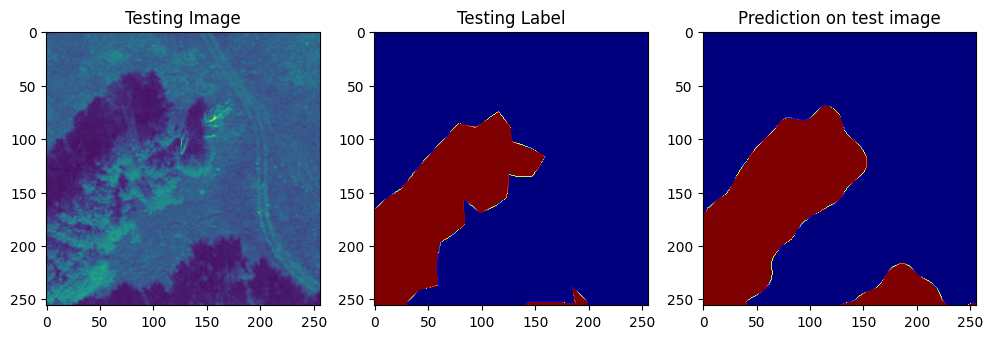

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


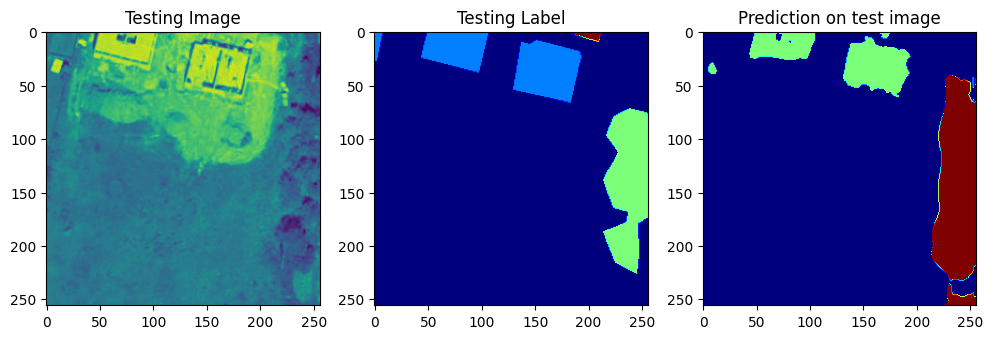

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


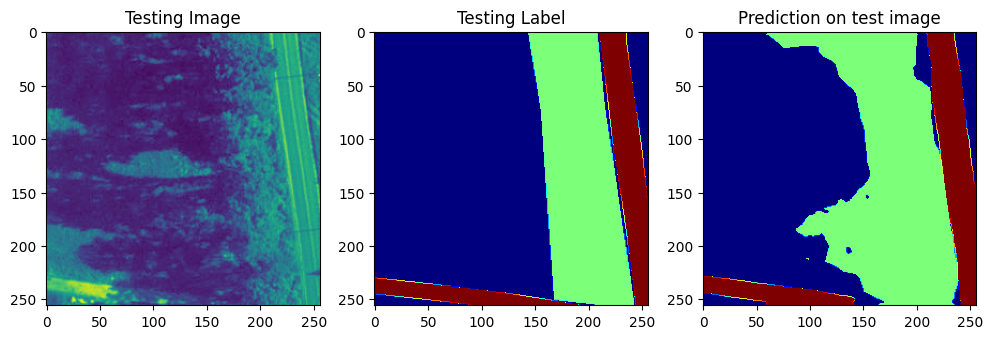

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


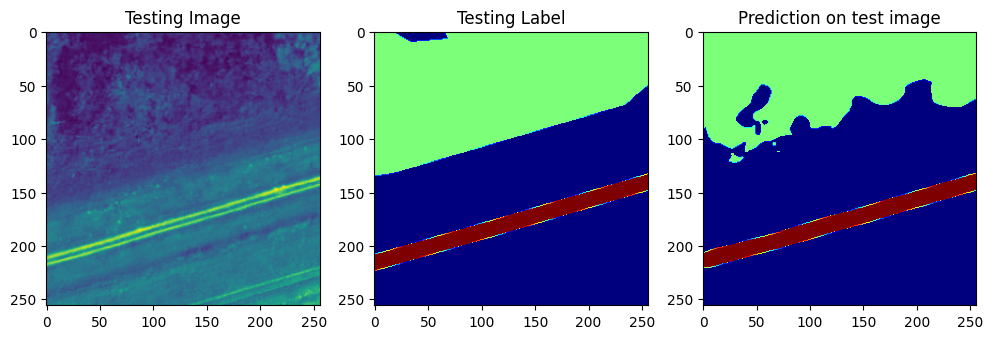

(1, 256, 256, 3)
1/1 [==============================] - 0s 111ms/step
(256, 256)


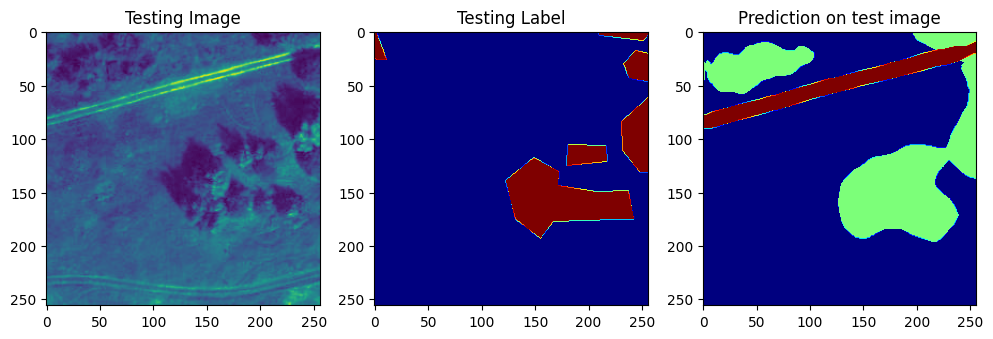

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


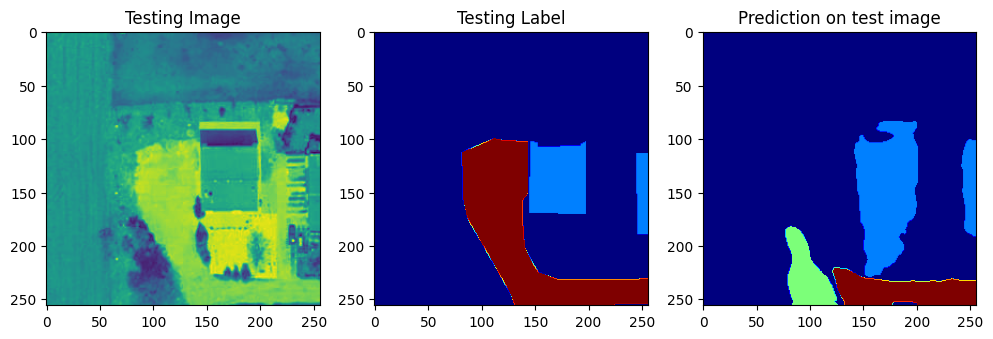

In [12]:
# Test some random images
for j in range(20):
    import random
    test_img_number = random.randint(0, len(X_test1)-1)
    test_img = X_test1[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    
    test_img_input1 = preprocess_input1(test_img_input)
    print(test_img_input1.shape)
    test_pred1 = model1.predict(test_img_input1)
    test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
    print(test_prediction1.shape)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction1, cmap='jet')
    plt.show()

In [ ]:
"""
https://github.com/Vooban/Smoothly-Blend-Image-Patches
"""

import cv2
import numpy as np

from matplotlib import pyplot as plt
import segmentation_models as sm

from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from keras.models import load_model
import time
# Set your backbone, preprocess_input, patch_size, and n_classes here
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# size of patches
patch_size = 256

# Number of classes 
n_classes = 5

# Specify the directory containing the images
image_directory = "../LargeImages/images"
mask_directory = "../LargeImages/masks"

# Define the result directory
result_directory_mask = f'segmentation_results/{BACKBONE}/mask/'
result_directory_segmented = f'segmentation_results/{BACKBONE}/segmented/'
os.makedirs(result_directory_mask, exist_ok=True)
os.makedirs(result_directory_segmented, exist_ok=True)

# List all image files in the directory
image_files = [file for file in os.listdir(image_directory) if file.endswith(".tif")]

# Load the model
model = load_model(f'../Segmentation_Models/{BACKBONE}/CheckPoints/weights-improvement_{BACKBONE}.hdf5', compile=False)

# Loop through each image file in the directory
for image_file in image_files:
    # Load the image
    img = cv2.imread(os.path.join(image_directory, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_img = preprocess_input(img)

    # Load the corresponding mask
    mask_file = os.path.splitext(image_file)[0] + ".tif"
    original_mask = cv2.imread(os.path.join(mask_directory, mask_file))
    # original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
    original_mask = original_mask[:, :, 0]

    # Predict using smooth blending
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2,
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )
    time.sleep(75)
    final_prediction = np.argmax(predictions_smooth, axis=2).astype(np.uint8)

    # Save the final prediction and original mask
    result_image_file = f'{result_directory_segmented}{os.path.splitext(image_file)[0]}_segmented_{BACKBONE}.tif'
    result_mask_file = f'{result_directory_mask}{os.path.splitext(image_file)[0]}_mask_{BACKBONE}.tif'
    print(result_image_file)
    print(result_mask_file)
    tiff.imwrite(result_image_file, final_prediction)
    tiff.imwrite(result_mask_file, original_mask)
    # Display the images if needed
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(img)
    plt.subplot(222)
    plt.title('Testing Label')
    plt.imshow(original_mask, cmap = 'gray')
    plt.subplot(223)
    plt.title('Prediction with smooth blending')
    plt.imshow(final_prediction, cmap= 'gray')
    plt.show()
